<a href="https://colab.research.google.com/github/buisonanh/phishing_urls_detection/blob/main/phishing_urls_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [280]:
import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [281]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [282]:
legit = pd.read_csv("/content/drive/MyDrive/DA20 - Final Project/Supervised Learning/legitimate_urls.csv")
phishing = pd.read_csv("/content/drive/MyDrive/DA20 - Final Project/Supervised Learning/phishing_urls.csv")

In [283]:
legit.drop_duplicates()
phishing.drop_duplicates()


print(legit.info())
print(phishing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31085 entries, 0 to 31084
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     31085 non-null  object
dtypes: object(1)
memory usage: 243.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56591 entries, 0 to 56590
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     56591 non-null  object
dtypes: object(1)
memory usage: 442.2+ KB
None


In [284]:
# add a 'status' column to the dataframes
legit["status"] = "legitimate"
phishing["status"] = "phishing"

print(legit)
# combine the two dataframes
df = pd.concat([legit, phishing], ignore_index=True)

# shuffle the dataframe's rows randomly
df = df.sample(frac=1, random_state=42) # Set random_state to an integer for reproducibility

df.info()

                      url      status
0          000webhost.com  legitimate
1               007go.com  legitimate
2                 010.com  legitimate
3        022menchuang.net  legitimate
4           050anshin.com  legitimate
...                   ...         ...
31080       crestbook.com  legitimate
31081          fumbbl.com  legitimate
31082          proplay.ru  legitimate
31083    jeuxdecartes.net  legitimate
31084  molehillempire.com  legitimate

[31085 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87676 entries, 61210 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     87676 non-null  object
 1   status  87676 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [285]:
# Identify duplicate rows
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicates: {num_duplicates}")

df = df.drop_duplicates()

duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicates: {num_duplicates}")


Number of duplicates: 220
Number of duplicates: 0


In [286]:
import re
df["url"] = df["url"].apply(lambda x: re.sub('[/\.;?=https:\']', ' ', x))

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87456 entries, 61210 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     87456 non-null  object
 1   status  87456 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [288]:
df.isnull().sum()
df.dropna(inplace = True)
df.head(30)

,url,status
61210,u -rediliver makeyourw com u veri...,phishing
8914,ren acar fr,legitimate
69536,587c88df-b417-4d76-9193-26ff31ef6f64 i...,phishing
62196,www kuerennkaycoa o co j kuercnnkaycea...,phishing
36231,qrco de bd 7VB rackid eCY j8 V9ffkdrY...,phishing
4199,free a ern com,legitimate
14680,zeeuw arc ief nl,legitimate
42990,u en e-webinfo-login 199-188-203-93 c ...,phishing
44582,7 95-214-24-226 c ra id com,phishing
73924,jofra afari co ke #,phishing


In [289]:
# assume `data` is a pandas DataFrame with columns "url" and "status"
counts = df["status"].value_counts()

# print the counts for each category
print(counts)

phishing      56587
legitimate    30869
Name: status, dtype: int64


In [290]:
# Data selection
feature_df = df['url']
status_df = df['status']

# Transform data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Vectorize URLs
vectorizer = CountVectorizer()
feature_vec = vectorizer.fit_transform(feature_df)

# Encode status column
label_encoder = LabelEncoder()
status_arr = label_encoder.fit_transform(status_df)

# Get class labels and corresponding encoded values
class_labels = label_encoder.classes_
class_encodings = label_encoder.transform(class_labels)

# Print class labels and their corresponding encoded values
for label, encoding in zip(class_labels, class_encodings):
    print(f"{encoding} -> {label}")


0 -> legitimate
1 -> phishing


In [291]:
print(feature_vec)

  (0, 78669)	1
  (0, 64697)	1
  (0, 33410)	1
  (0, 85790)	1
  (0, 55737)	1
  (1, 79028)	1
  (1, 18322)	1
  (1, 48289)	1
  (2, 11055)	1
  (2, 25536)	1
  (2, 9788)	1
  (2, 15483)	1
  (2, 5195)	1
  (2, 52832)	1
  (2, 78411)	1
  (2, 33100)	1
  (3, 33100)	1
  (3, 89321)	1
  (3, 60567)	1
  (3, 60562)	1
  (3, 84347)	1
  (4, 76864)	1
  (4, 35779)	1
  (4, 27548)	1
  (4, 13996)	1
  :	:
  (87452, 58008)	1
  (87452, 62016)	1
  (87452, 89334)	1
  (87452, 89666)	1
  (87452, 78384)	1
  (87452, 68162)	1
  (87452, 771)	1
  (87452, 56130)	1
  (87452, 92428)	1
  (87452, 15233)	1
  (87452, 51789)	1
  (87452, 74608)	1
  (87453, 55684)	1
  (87453, 47676)	1
  (87453, 85565)	1
  (87453, 76307)	1
  (87453, 13978)	1
  (87454, 33410)	1
  (87454, 23477)	1
  (87454, 39403)	1
  (87454, 53578)	1
  (87454, 84251)	1
  (87455, 80910)	1
  (87455, 79631)	1
  (87455, 74453)	1


In [292]:
"""
from imblearn.over_sampling import RandomOverSampler

# create a RandomOverSampler object and fit it to the data
oversampler = RandomOverSampler(random_state=42)
feature_vec_balanced, status_arr_balanced = oversampler.fit_resample(feature_vec, status_arr)

# check the new class distribution
pd.Series(status_arr_balanced).value_counts()
"""

'\nfrom imblearn.over_sampling import RandomOverSampler\n\n# create a RandomOverSampler object and fit it to the data\noversampler = RandomOverSampler(random_state=42)\nfeature_vec_balanced, status_arr_balanced = oversampler.fit_resample(feature_vec, status_arr)\n\n# check the new class distribution\npd.Series(status_arr_balanced).value_counts()\n'

In [293]:
#chia tap train, test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_vec, status_arr, test_size=0.25, random_state=42)

print('Train: ', x_train.shape[0])
print('Test: ', x_test.shape[0])

Train:  65592
Test:  21864


In [294]:

#modeling lbfgs
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C= 0.1, class_weight= None, max_iter= 9000, penalty= 'l2',random_state=42)
lr_lbfgs = logreg.fit(x_train,y_train)


In [295]:
"""
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'max_iter': [100, 500, 1000],
              'class_weight': [None, 'balanced']}

grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


# Output:
# Best parameters: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2'}
# Best cross-validation score: 0.9286404335532517
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\'C\': [0.001, 0.01, 0.1, 1, 10],\n              \'penalty\': [\'l1\', \'l2\'],\n              \'max_iter\': [100, 500, 1000],\n              \'class_weight\': [None, \'balanced\']}\n\ngrid_search = GridSearchCV(LogisticRegression(solver=\'lbfgs\'),\n                           param_grid,\n                           cv=5,\n                           scoring=\'accuracy\',\n                           n_jobs=-1)\n\ngrid_search.fit(x_train, y_train)\n\nprint(f"Best parameters: {grid_search.best_params_}")\nprint(f"Best cross-validation score: {grid_search.best_score_}")\n\n\n# Output:\n# Best parameters: {\'C\': 10, \'class_weight\': None, \'max_iter\': 100, \'penalty\': \'l2\'}\n# Best cross-validation score: 0.9286404335532517\n'

In [296]:
y_pred=logreg.predict(x_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [297]:
from sklearn.metrics import jaccard_score
print(jaccard_score(y_test, y_pred,pos_label=0))

0.7315105803477896


In [298]:
logreg.score(x_test, y_test)

0.8827753384559093

In [299]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")


Accuracy: 0.88
F1 score: 0.91


In [300]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 6983,   745],
       [ 1818, 12318]])

Text(0.5, 427.9555555555555, 'Predicted label')

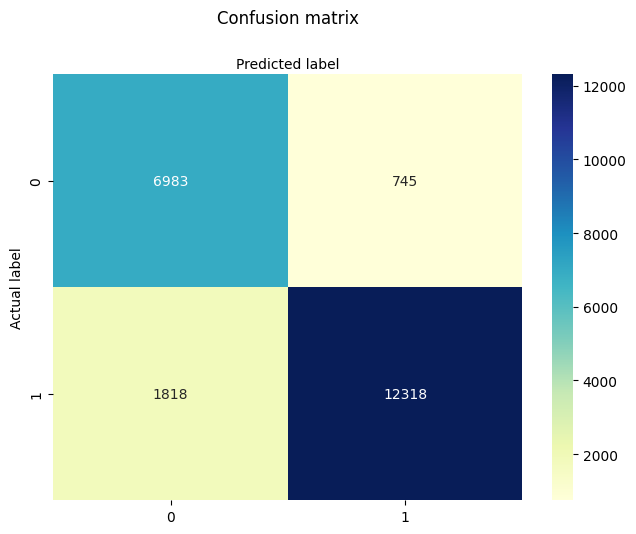

In [301]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [302]:
"""
new_url = input('Enter an URL to test: ')

# Transform features into same format as training data
new_vector = vectorizer.transform([new_url])

# Make prediction using trained model
prediction = logreg.predict(new_vector)

if prediction[0] == 0:
  print('Legitimate')
else:
  print('Phishing')
"""

"\nnew_url = input('Enter an URL to test: ')\n\n# Transform features into same format as training data\nnew_vector = vectorizer.transform([new_url])\n\n# Make prediction using trained model\nprediction = logreg.predict(new_vector)\n\nif prediction[0] == 0:\n  print('Legitimate')\nelse:\n  print('Phishing')\n"

## Test

In [303]:
test_df = pd.read_csv('/content/drive/MyDrive/DA20 - Final Project/Supervised Learning/publish_test.csv')
test_df.head(30)

,x,y,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,http://newmatdesign.ro/wp-admin/wewe/YAHOO/ya....,1,NaN,NaN,NaN
1,http://ca.linkedin.com/directory/people/ca/pou...,0,NaN,NaN,NaN
2,http://www.ccent.com.au/index.php?option=com_m...,1,NaN,NaN,NaN
3,http://applerugs.co.uk/rugs/product_info.php?p...,1,NaN,NaN,NaN
4,http://mo-artworks.com/blog/diverse-videos/ein...,1,NaN,NaN,NaN
5,http://spoke.com/info/pF2WnMN/ZachTrimmer,0,NaN,NaN,NaN
6,http://www.ricardoitalo.com.br/portal/index.ph...,1,NaN,NaN,NaN
7,http://sexshop-bg.biz/products?page=shop.produ...,1,NaN,NaN,NaN
8,http://www.beriva.lt/index.html?di=akcijos&R=1...,1,NaN,NaN,NaN
9,http://ma.facevena.xyz/app/facebook.com/?lang=...,1,NaN,NaN,NaN


In [304]:
test = test_df[['x','y']]

test.isnull().sum()
test.dropna()

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x       100 non-null    object
 1   y       100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [305]:
indexValue = test[test['y'] == 'continue=to&amp'].index
test.drop(indexValue , inplace=True)

<ipython-input-305-d25c9236987c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(indexValue , inplace=True)


In [306]:
x_t = test['x']
y_t = test['y'].astype(int)


x_t = vectorizer.transform(x_t)
y_t = np.asarray(y_t)
print(y_t)

y_pred_t = logreg.predict(x_t)
print(y_pred_t)

[1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0
 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1]
[1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0
 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1]


In [307]:
logreg.score(x_t, y_t)

0.8080808080808081

In [308]:
from sklearn.metrics import jaccard_score
print(jaccard_score(y_t, y_pred_t,pos_label=0))

0.6779661016949152


In [309]:
accuracy = accuracy_score(y_t, y_pred_t)
f1 = f1_score(y_t, y_pred_t)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.81
F1 score: 0.81


Text(0.5, 427.9555555555555, 'Predicted label')

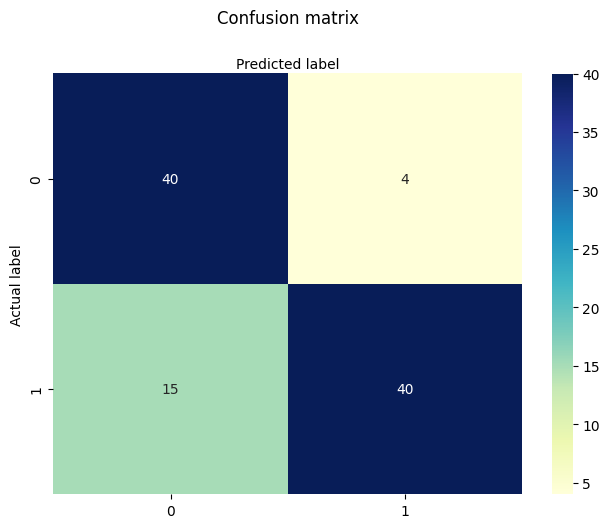

In [310]:
cnf_matrix = metrics.confusion_matrix(y_t, y_pred_t)
cnf_matrix

class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')